In [2]:
from features import (
    sentence_length,
    word_frequency,
    punctuation_ratio,
    avg_word_length,
    lexical_diversity,
    emoji_frequency,
    semantic_coherence,
    repetition_patterns,
    calculate_burstiness
)

from features import llm_score


In [3]:
import pandas as pd


def feature_extraction(text):
    # 提取统计特征
    features = {}
    
    # 句子长度特征
    sentence_features = sentence_length(text)
    features.update(sentence_features)
    
    # 词频特征
    word_freq_features = word_frequency(text)
    features.update(word_freq_features)
    
    # 标点符号特征
    punct_features = punctuation_ratio(text)
    features.update(punct_features)
    
    # 平均词长特征
    #avg_word_length_features = avg_word_length(text)
    #features.update(avg_word_length_features)
    
    # 词汇多样性特征
    lexical_features = lexical_diversity(text)
    features.update(lexical_features)
    
    # emoji特征
    emoji_features = emoji_frequency(text)
    features.update(emoji_features)

    features.update(semantic_coherence(text))
    features.update(repetition_patterns(text))
    features.update(calculate_burstiness(text))


    # 提取llm特征
    #llm_features = llm_score(text)
    #features.update(llm_features)

    return features


df = pd.DataFrame(columns=list(feature_extraction("你们有没有过这样的经历\n图片看着挺好看，但自己一剪就不是那么回事\n不是你不适合剪\n而是最适合的长度 细节没有掌握到\n赶快拿着这个视频去给你的Tony老师吧[害羞R]").keys()) + ['label'])

import json
import threading
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

def process_line(line):
    """处理单行数据的函数"""
    data = json.loads(line)
    features = feature_extraction(data['desc'])
    features["label"] = data['model']
    return features

# 读取所有行
lines = []
with open('dataset/AIGC_training_set.jsonl') as f:
    lines = f.readlines()

# 使用线程池处理数据
results = []
with ThreadPoolExecutor(max_workers=20) as executor:
    results = list(executor.map(process_line, lines[:10]))

# 将结果添加到DataFrame
for features in results:
    df.loc[len(df)] = features


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


训练集准确率: 0.7416
验证集准确率: 0.7291

特征重要性 (系数和比值比):
                             Feature  Coefficient  Odds Ratio
18                     emoji_density     3.865036   47.704994
15                          root_ttr     2.360327   10.594412
0                avg_sentence_length     1.558539    4.751872
21                 topic_consistency     1.533344    4.633646
17                unique_emoji_ratio     0.832425    2.298887
6                  unique_word_ratio     0.562445    1.754957
13                               ttr     0.562445    1.754957
40       rhetorical_device_frequency     0.256242    1.292066
33        vocabulary_personalization     0.249332    1.283167
3                sentence_length_std     0.188726    1.207710
30     personal_emotional_expression     0.131116    1.140100
34             natural_language_flow     0.097533    1.102447
32                 life_authenticity     0.087418    1.091353
37         communication_naturalness     0.059628    1.061442
26                   wo

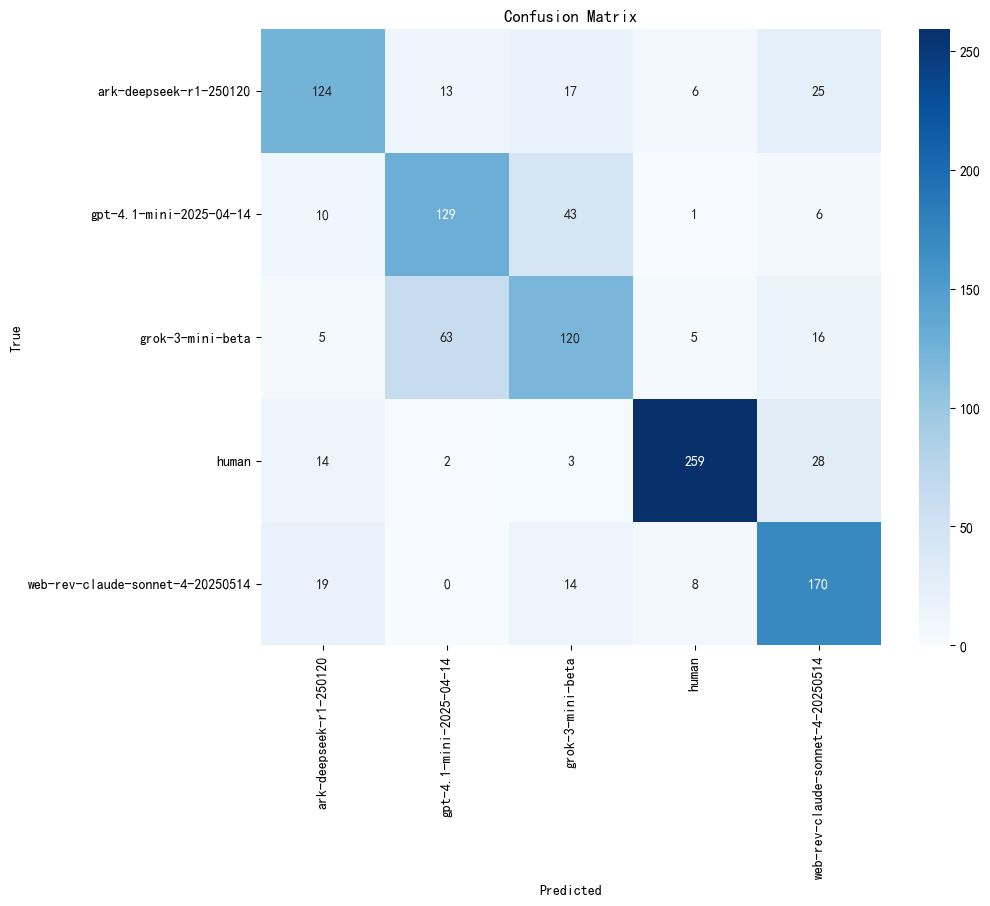


混淆矩阵:
[[124  13  17   6  25]
 [ 10 129  43   1   6]
 [  5  63 120   5  16]
 [ 14   2   3 259  28]
 [ 19   0  14   8 170]]


In [13]:
# 打乱数据
df = df.sample(frac=1, random_state=42)

# 划分训练集和验证集
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
val_df = df[train_size:]

# 准备特征和标签
X_train = train_df.iloc[:, :-1]  # 前x列作为特征
y_train = train_df.iloc[:, -1]   # 最后一列作为标签
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1]

# 构建并训练多类别分类器
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

# 在验证集上评估
train_score = clf.score(X_train, y_train)
val_score = clf.score(X_val, y_val)

print(f"训练集准确率: {train_score:.4f}")
print(f"验证集准确率: {val_score:.4f}")

# 输出特征重要性
import numpy as np
coefficients = clf.coef_[0]
odds_ratios = np.exp(coefficients)

# 显示特征重要性
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\n特征重要性 (系数和比值比):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

# 输出混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 在验证集上进行预测
y_pred = clf.predict(X_val)

# 计算混淆矩阵
cm = confusion_matrix(y_val, y_pred)

# 绘制混淆矩阵热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_,
            yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 打印混淆矩阵数值
print("\n混淆矩阵:")
print(cm)


In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def process_travel_line(line):
    """处理数据的单行"""
    try:
        data = json.loads(line)
        # 提取特征
        features = feature_extraction(data['desc'])
        
        # 提取时间信息
        local_time = data.get('local_time', '')
        if len(local_time) >= 8:
            # local_time格式: "2024122721" -> "2024-12-27"
            year = local_time[:4]
            month = local_time[4:6]
            day = local_time[6:8]
            date_str = f"{year}-{month}-{day}"
        else:
            date_str = None
            
        return {
            'features': features,
            'date': date_str,
            'note_id': data.get('note_id', ''),
            'title': data.get('note_title', ''),
            'desc': data['desc'],
            'domain': data['domain'],
            'liked_count': data.get('liked_count', '0'),
            'collected_count': data.get('collected_count', '0'),
            'comments_count': data.get('comments_count', '0')
        }
    except Exception as e:
        print(f"处理数据时出错: {e}")
        return None

print("开始读取推理数据...")
# 读取推理数据
travel_lines = []
with open('/Users/lyd/Downloads/0523/dataset/dataset_0703.jsonl', 'r', encoding='utf-8') as f:
    travel_lines = f.readlines()

print(f"共读取 {len(travel_lines)} 条数据")

# 使用线程池处理数据
print("开始提取特征...")
travel_results = []
with ThreadPoolExecutor(max_workers=200) as executor:
    results = list(executor.map(process_travel_line, travel_lines))
    travel_results = [r for r in results if r is not None]

print(f"成功处理 {len(travel_results)} 条数据")


开始读取推理数据...
共读取 42037 条数据
开始提取特征...
成功处理 42037 条数据


In [15]:
# 准备预测数据
print("开始进行模型预测...")
predictions = []
dates = []
likes = []
collecteds = []
comments = []
valid_results = []
domains = []

for result in travel_results:
    if result['date'] is not None:
        # 准备特征向量
        feature_vector = []
        for col in X_train.columns:
            feature_vector.append(result['features'].get(col, 0))
        
        # 进行预测
        pred = clf.predict([feature_vector])[0]
        predictions.append(pred)
        dates.append(result['date'])
        likes.append(result['liked_count'])
        collecteds.append(result['collected_count'])
        comments.append(result['comments_count'])
        valid_results.append(result)
        domains.append(result['domain'])

print(f"完成 {len(predictions)} 条数据的预测")

# 创建预测结果DataFrame
pred_df = pd.DataFrame({
    'date': dates,
    'predicted_model': predictions,
    'likes': likes,
    'collecteds': collecteds,
    'comments': comments,
    'domain': domains
})

# 转换日期格式并提取年月
pred_df['date'] = pd.to_datetime(pred_df['date'])
pred_df['year_month'] = pred_df['date'].dt.to_period('M')

print("预测结果统计:")
print(pred_df['predicted_model'].value_counts())
print(f"\n时间范围: {pred_df['date'].min()} 到 {pred_df['date'].max()}")


开始进行模型预测...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarnin

完成 42037 条数据的预测
预测结果统计:
predicted_model
human                               33712
gpt-4.1-mini-2025-04-14              5174
ark-deepseek-r1-250120               1813
grok-3-mini-beta                     1113
web-rev-claude-sonnet-4-20250514      225
Name: count, dtype: int64

时间范围: 2023-02-02 00:00:00 到 2025-07-02 00:00:00


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarnin

In [16]:
# 按月统计各AI模型的数量和占比
monthly_stats = pred_df.groupby(['year_month', 'predicted_model']).size().unstack(fill_value=0)

# 计算每月的总数和占比
monthly_totals = monthly_stats.sum(axis=1)
monthly_proportions = monthly_stats.div(monthly_totals, axis=0) * 100

print("每月各模型数量统计:")
print(monthly_stats)
print("\n每月各模型占比统计(%):")
print(monthly_proportions.round(2))

# 确保所有模型都在列中（如果某个月某个模型为0）
all_models = sorted(pred_df['predicted_model'].unique())
for model in all_models:
    if model not in monthly_proportions.columns:
        monthly_proportions[model] = 0

# 重新排序列
monthly_proportions = monthly_proportions[all_models]

print(f"\n检测到的AI模型: {all_models}")
print(f"时间跨度: {len(monthly_proportions)} 个月")


每月各模型数量统计:
predicted_model  ark-deepseek-r1-250120  gpt-4.1-mini-2025-04-14  \
year_month                                                         
2023-02                               0                        9   
2023-03                               1                       13   
2023-04                               1                        6   
2023-05                               4                        9   
2023-06                               3                       19   
2023-07                               2                       29   
2023-08                               7                       28   
2023-09                               2                       24   
2023-10                               0                       13   
2023-11                               8                       27   
2023-12                               2                       20   
2024-01                               7                       40   
2024-02                              

每周Human vs AIGC数量统计:
model_category         AIGC  Human
year_week                         
2024-04-01/2024-04-07    21     57
2024-04-08/2024-04-14    18     54
2024-04-15/2024-04-21    22     73
2024-04-22/2024-04-28    24     75
2024-04-29/2024-05-05    17     44
...                     ...    ...
2025-06-02/2025-06-08   490   1792
2025-06-09/2025-06-15   651   2456
2025-06-16/2025-06-22   576   2702
2025-06-23/2025-06-29   732   4319
2025-06-30/2025-07-06   176   1196

[66 rows x 2 columns]

每周Human vs AIGC占比统计(%):
model_category          AIGC  Human
year_week                          
2024-04-01/2024-04-07  26.92  73.08
2024-04-08/2024-04-14  25.00  75.00
2024-04-15/2024-04-21  23.16  76.84
2024-04-22/2024-04-28  24.24  75.76
2024-04-29/2024-05-05  27.87  72.13
...                      ...    ...
2025-06-02/2025-06-08  21.47  78.53
2025-06-09/2025-06-15  20.95  79.05
2025-06-16/2025-06-22  17.57  82.43
2025-06-23/2025-06-29  14.49  85.51
2025-06-30/2025-07-06  12.83  87.17

[66 row

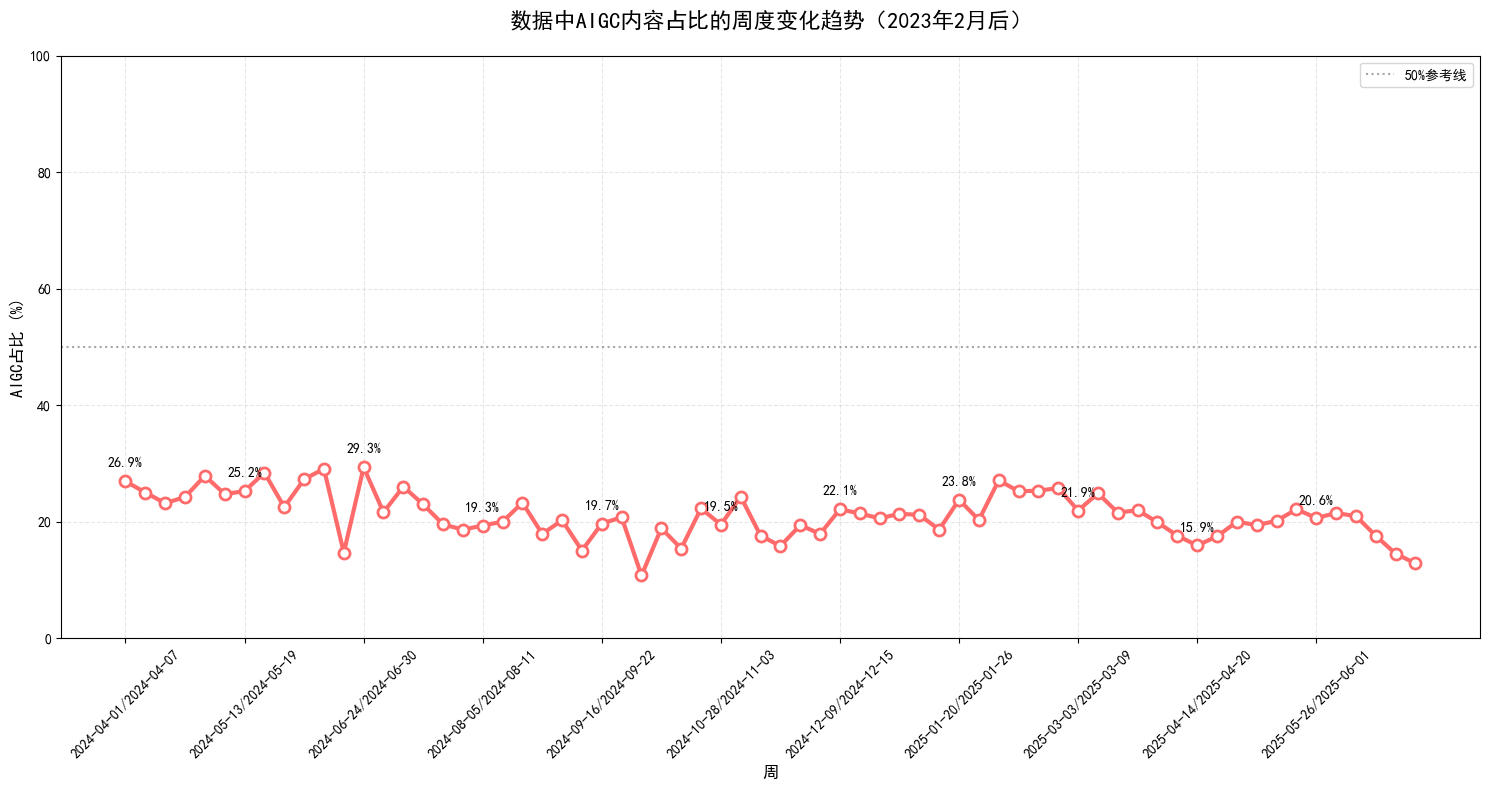


=== 详细统计信息 ===
总样本数: 40452
时间跨度: 2024-04-01 到 2025-07-02
涵盖周数: 66

Human vs AIGC总体占比:
Human: 80.47%
AIGC: 19.53%

每周数据量:
2024-04-01/2024-04-07: 78 条
2024-04-08/2024-04-14: 72 条
2024-04-15/2024-04-21: 95 条
2024-04-22/2024-04-28: 99 条
2024-04-29/2024-05-05: 61 条
2024-05-06/2024-05-12: 89 条
2024-05-13/2024-05-19: 103 条
2024-05-20/2024-05-26: 88 条
2024-05-27/2024-06-02: 120 条
2024-06-03/2024-06-09: 121 条
2024-06-10/2024-06-16: 141 条
2024-06-17/2024-06-23: 150 条
2024-06-24/2024-06-30: 191 条
2024-07-01/2024-07-07: 236 条
2024-07-08/2024-07-14: 269 条
2024-07-15/2024-07-21: 257 条
2024-07-22/2024-07-28: 261 条
2024-07-29/2024-08-04: 263 条
2024-08-05/2024-08-11: 300 条
2024-08-12/2024-08-18: 310 条
2024-08-19/2024-08-25: 271 条
2024-08-26/2024-09-01: 257 条
2024-09-02/2024-09-08: 252 条
2024-09-09/2024-09-15: 266 条
2024-09-16/2024-09-22: 249 条
2024-09-23/2024-09-29: 270 条
2024-09-30/2024-10-06: 223 条
2024-10-07/2024-10-13: 281 条
2024-10-14/2024-10-20: 234 条
2024-10-21/2024-10-27: 220 条
2024-10-28/2024

In [17]:
# 创建新的分类：将除human外的所有模型归类为AIGC
pred_df_grouped = pred_df.copy()
pred_df_grouped['model_category'] = pred_df_grouped['predicted_model'].apply(
    lambda x: 'Human' if x == 'human' else 'AIGC'
)

# 筛选2023-02之后的数据
pred_df_grouped = pred_df_grouped[
    (pred_df_grouped['date'] >= '2024-04-01') #& 
    #(pred_df_grouped['domain'] == "旅行")
]

# 添加年周列
pred_df_grouped['year_week'] = pred_df_grouped['date'].dt.to_period('W')

# 按周统计Human和AIGC的数量和占比
weekly_stats_grouped = pred_df_grouped.groupby(['year_week', 'model_category']).size().unstack(fill_value=0)

# 计算每周的总数和占比
weekly_totals_grouped = weekly_stats_grouped.sum(axis=1)
weekly_proportions_grouped = weekly_stats_grouped.div(weekly_totals_grouped, axis=0) * 100

print("每周Human vs AIGC数量统计:")
print(weekly_stats_grouped)
print("\n每周Human vs AIGC占比统计(%):")
print(weekly_proportions_grouped.round(2))

# 绘制AIGC占比变化的折线图
plt.figure(figsize=(15, 8))

# 转换时间索引为字符串格式便于显示
time_labels = [str(period) for period in weekly_proportions_grouped.index]

# 提取AIGC占比数据
if 'AIGC' in weekly_proportions_grouped.columns:
    aigc_proportions = weekly_proportions_grouped['AIGC'].values
else:
    aigc_proportions = np.zeros(len(weekly_proportions_grouped))

# 绘制折线图
plt.plot(range(len(weekly_proportions_grouped)), aigc_proportions, 
         marker='o', linewidth=3, markersize=8, color='#FF6B6B', 
         markerfacecolor='white', markeredgewidth=2, markeredgecolor='#FF6B6B')

# 添加数据点标签（只在部分点上显示，避免过于密集）
step = max(1, len(aigc_proportions) // 10)  # 最多显示10个标签
for i in range(0, len(aigc_proportions), step):
    plt.annotate(f'{aigc_proportions[i]:.1f}%', 
                (i, aigc_proportions[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', 
                fontsize=10,
                fontweight='bold')

# 设置图表属性
plt.title('数据中AIGC内容占比的周度变化趋势（2023年2月后）', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('周', fontsize=12)
plt.ylabel('AIGC占比 (%)', fontsize=12)

# 设置x轴标签（只显示部分标签避免重叠）
step_x = max(1, len(time_labels) // 10)
plt.xticks(range(0, len(time_labels), step_x), 
           [time_labels[i] for i in range(0, len(time_labels), step_x)], 
           rotation=45)

# 设置y轴范围
plt.ylim(0, 100)

# 添加网格
plt.grid(True, alpha=0.3, linestyle='--')

# 添加水平参考线
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.7, label='50%参考线')

# 设置图例
plt.legend(fontsize=10)

# 调整布局
plt.tight_layout()

# 显示图表
plt.show()

# 打印详细统计信息
print("\n=== 详细统计信息 ===")
print(f"总样本数: {len(pred_df_grouped)}")
print(f"时间跨度: {pred_df_grouped['date'].min().strftime('%Y-%m-%d')} 到 {pred_df_grouped['date'].max().strftime('%Y-%m-%d')}")
print(f"涵盖周数: {len(weekly_proportions_grouped)}")

print("\nHuman vs AIGC总体占比:")
overall_proportions_grouped = pred_df_grouped['model_category'].value_counts(normalize=True) * 100
for category, prop in overall_proportions_grouped.items():
    print(f"{category}: {prop:.2f}%")

print("\n每周数据量:")
for period, total in weekly_totals_grouped.items():
    print(f"{period}: {total} 条")

print("\n原始AI模型分布:")
original_ai_models = pred_df_grouped[pred_df_grouped['predicted_model'] != 'human']['predicted_model'].value_counts()
if len(original_ai_models) > 0:
    print("被归类为AIGC的模型:")
    for model, count in original_ai_models.items():
        print(f"  {model}: {count} 条")
else:
    print("  无AI生成内容")
